# First test Training of car detection semantic segmentation

### imports

In [1]:
from fastai.vision.all import *
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import os
import shutil
import random
from pathlib import Path
import geopandas as gpd
import osmnx as ox


In [2]:

# check if cuda is available
print(torch.cuda.is_available())

# clear cuda cache
torch.cuda.empty_cache()

# get free gpu memory
!nvidia-smi

True
Tue Jan 23 21:09:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1070      WDDM  | 00000000:2B:00.0  On |                  N/A |
| 18%   33C    P8              19W / 250W |   1225MiB /  8192MiB |     12%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+--------------------

## Image Segmentation

In [3]:
# define a function to get the images
def get_images(name):
      # Create a Path object for the specified directory
    dir_path = Path("./train_test_split_car")

    # Use glob to find files matching the specified pattern
    image_files = dir_path.glob("**/img.jpg")

    # Return the list of image files
    return list(image_files)

In [4]:
# define a function to get the numpy mask for the given path
def get_mask(path):
    #remove the file name and extension from the path
    path = path.parent 
    # add the name mask.npy to the path
    path = path.joinpath("label.npy")
    return np.load(path)

### create a data block for car

In [5]:
aerial_Block = DataBlock(blocks = (ImageBlock, MaskBlock(codes = ["background","car"])),
                            splitter=GrandparentSplitter(train_name='train', valid_name='test'),
                            get_items=get_images,
                            get_y=get_mask,
                            batch_tfms=aug_transforms(size=500, max_lighting=0.3))

In [6]:
dataloader_car = aerial_Block.dataloaders("./",bs=4)

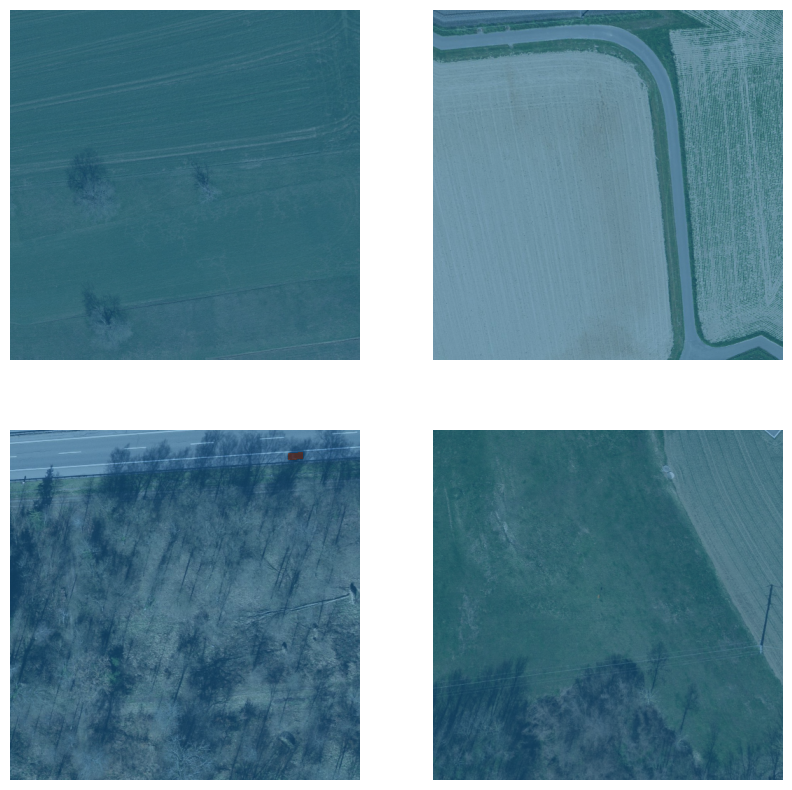

In [7]:
dataloader_car.show_batch(max_n=4,figsize=(10,10))

### create a Datablock for street

In [8]:
def mask_function_street(name):
    return np.load(str(name).replace("img.png", "label_street_mask.npy"))

def get_images_street(name):
      # Create a Path object for the specified directory
    dir_path = Path("./train_test_split_street")

    # Use glob to find files matching the specified pattern
    image_files = dir_path.glob("**/img.png")

    # Return the list of image files
    return list(image_files)

In [9]:
satellite_block = DataBlock(blocks = (ImageBlock, MaskBlock(codes = ["background","street"])),
                 splitter=GrandparentSplitter(train_name='train', valid_name='test'),
                 get_items=get_images_street,
                 get_y=mask_function_street,
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=256, max_lighting=0.3)
)
dataloader_street = satellite_block.dataloaders("./", bs=4)

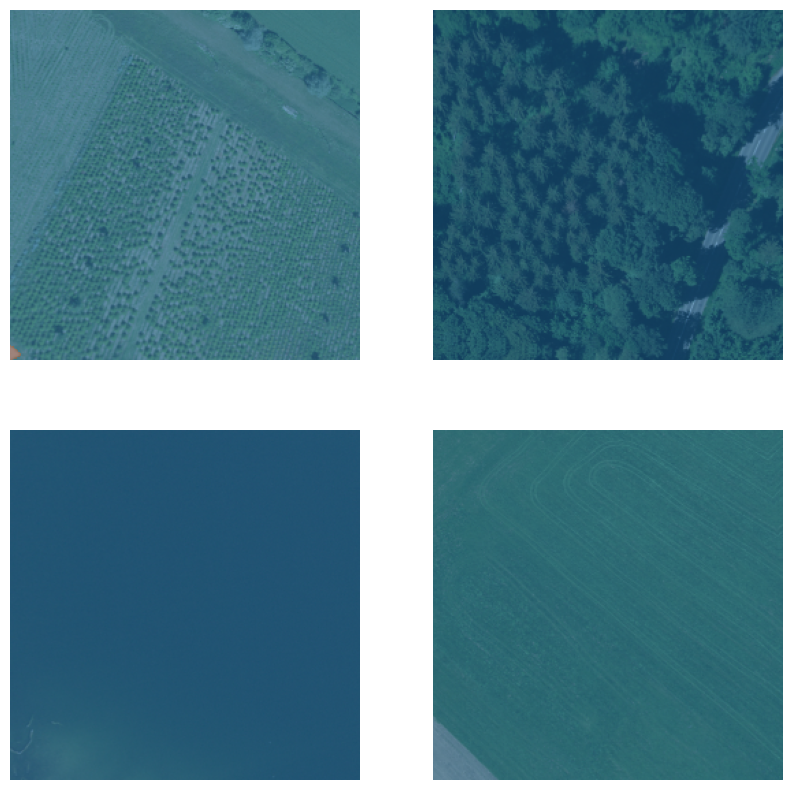

In [10]:
dataloader_street.show_batch(max_n=4,figsize=(10,10))

## Load The Models

In [11]:
learner_car = unet_learner(dataloader_car,resnet34,metrics=Dice)
learner_car = learner_car.load('model_downloaded')

c:\Users\benev\AppData\Local\Programs\Python\Python39\lib\site-packages\fastai\learner.py:59: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


In [12]:
learner_street = unet_learner(dataloader_street,resnet34,metrics=Dice)
learner_street = learner_street.load('best_model_street')

## Show Results

In [13]:
learner_car.show_results(max_n=10, figsize=(100,100))

In [14]:
learner_street.show_results(max_n=10, figsize=(100,100))

### export model

In [15]:
learner_street.export(fname='exported_models/best_model_street.pkl')
learner_car.export(fname='exported_models/best_model_car.pkl')

## pipe models

In [16]:
street_inf = load_learner('exported_models/best_model_street.pkl')
car_inf = load_learner('exported_models/best_model_car.pkl')

In [17]:
image_path = "train_test_split_car/test/26742_12519/img.jpg"

In [18]:
# predict the image and convert it to a numpy array
prediction_street = street_inf.predict(image_path)[0].numpy()
prediction_street = np.array(Image.fromarray(prediction_street.astype(np.uint8)).resize((1000, 1000))).astype('float32')

prediction_car = car_inf.predict(image_path)[0].numpy()
prediction_car = np.array(Image.fromarray(prediction_car.astype(np.uint8)).resize((1000, 1000))).astype('float32')

In [19]:
# calculate intersect of arrays 
intersection = np.logical_and(prediction_street, prediction_car)

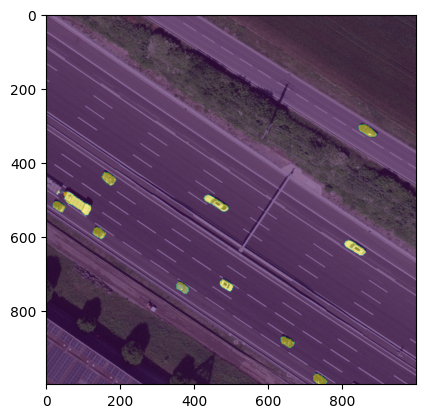

In [20]:
image = np.array(Image.open(image_path))

plt.imshow(image)
plt.imshow(intersection,alpha=0.5)
plt.plot();

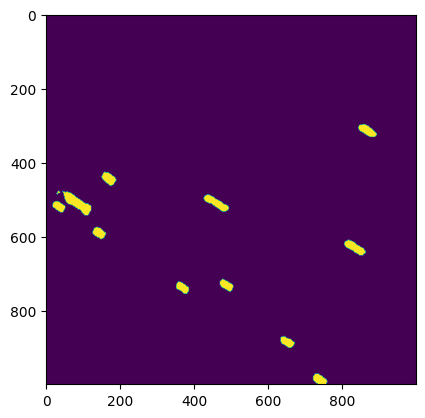

In [21]:
# show mask over image
plt.imshow(prediction_street)
plt.imshow(intersection)
plt.show()